In [1]:
import numpy as np
import numpy.random as npr
from scipy.linalg import solve_discrete_are

In [2]:
np.set_printoptions(precision=3, suppress=True)

In [3]:
hz = 60.0
_sat = 5.0
def f(s, a):
    th, x, thdot, xdot = s
    sdot = np.array([
                thdot, xdot,
                9.81*np.sin(th)/1.0+_sat*a[0]*np.cos(th)/1.0-0.2*thdot,
                _sat*a[0]-0.1*xdot])
    return s + sdot/hz

In [4]:
def wrap2Pi(x):
    th = np.fmod(x+np.pi, 2.0 * np.pi)
    if th < 0:
        th = th + 2.0 * np.pi
    return th - np.pi

Q = np.diag([10., 0.25, 0., 0.001, 0., 0., 0.])
Qf = np.diag([20., 0.2, 0., 0., 0., 0.,0.])
R = np.diag([0.01])

Rinv = np.linalg.inv(R)

def l(x): #loss in z space
    x[0] = wrap2Pi(x[0])
    return np.dot(x, np.dot(Q, x))

def ldx(x):
    x[0] = wrap2Pi(x[0])
    return 2.*np.dot(Q, x)

def m(x): #loss in z space
    x[0] = wrap2Pi(x[0])
    return np.dot(x, np.dot(Qf, x))

def mdx(x):
    x[0] = wrap2Pi(x[0])
    return 2.*np.dot(Qf, x)


In [5]:
state_dim = 4
action_dim = 1

num_x_obs = 7
num_u_obs = 2
num_obs = num_x_obs + num_u_obs

def z(s):
    th, x, thdot, xdot = s
    return np.array([th, x, thdot, xdot, np.sin(th), np.cos(th), 1.])

def v(s, a):
    th, x, thdot, xdot = s
    return np.array([a[0], np.cos(th) * a[0]])

def dvdu(s, a):
    return np.array([[1.0, np.cos(s[0])]]).T
    

In [6]:
npr.seed(0) ## set the seed for reproducibility 
num_trials = 60 ## number of resets
horizon    = 100 ## how long we simulate the system for
M = num_trials * horizon ## M sized data

_A = np.zeros((num_obs, num_obs))
_G = np.zeros((num_obs, num_obs))
# cnt = 0
s_bnds = np.array([6.24, 1.0, 2.0, 2.0])
a_bnds = np.array([1.])
## loop to collect data
for k in range(num_trials):
#     x_t = npr.uniform(low=-s_bnds, high=s_bnds)
    x_t = npr.normal(s_bnds*0., s_bnds)
    for t in range(horizon):
        u_t = npr.normal(0.*a_bnds, a_bnds)
        x_tpo = f(x_t, u_t)
        u_tpo = u_t

        z1 = np.concatenate([z(x_t), v(x_t, u_t)])
        z2 = np.concatenate([z(x_tpo), v(x_tpo, u_t)])
        _A += np.outer(z2, z1)
        _G += np.outer(z1, z1)
        
        # reset for next loop
        x_t = x_tpo
        u_t = u_tpo

        
# _A /= M
# _G /= M

K = np.dot(_A, np.linalg.pinv(_G, hermitian=True))
A = K[:num_x_obs,:num_x_obs]
B = K[:num_x_obs, num_x_obs:]

# A[np.abs(A)<1e-3] = 0
# B[np.abs(B)<1e-3] = 0

In [7]:
T = int(1.5*hz)
u = [np.zeros(1) for t in range(T)]
def update(x, u, A, B):
    zt = z(x.copy())
    zot = []
    for t in range(T):
        zt = z(zt[:state_dim])
        zot.append(zt.copy())
        zt = np.dot(A, zt) + np.dot(B, v(zt[:state_dim], u[t]))
    rho = np.zeros_like(zt)
    for t in reversed(range(T)):
        rho = ldx(zot[t].copy()) + np.dot(A.T, rho)
        Beff = np.dot(B, dvdu(zot[t], u[t]))
#         u[t] = np.clip(-Rinv.dot(Beff.T.dot(rho)), -1., 1.)
        du = Beff.T.dot(rho) + 2.0 * R.dot(u[t])
        u[t] = np.clip(u[t] - 0.1 * du, -1, 1)
    return u

In [8]:
xt = np.array([3.14, 0., 0., 0.])
trajectory = []

for t in range(int(50*hz)):
    u[:-1] = u[1:]
    u[-1] = np.zeros_like(u[-1])
    u = update(xt, u, A, B)

    u1 = u[0]
    xtpo = f(xt, u1)

    z1 = np.concatenate([z(xt), v(xt, u1)])
    z2 = np.concatenate([z(xtpo), v(xtpo, u1)])
    _A += np.outer(z2, z1)
    _G += np.outer(z1, z1)
    
    K = np.dot(_A, np.linalg.pinv(_G, hermitian=True))
    A = K[:num_x_obs,:num_x_obs]
    B = K[:num_x_obs, num_x_obs:]
    
    xt = xtpo
    
    trajectory.append(xt.copy())
    if t % 50 == 0:
        print(xt)

[ 3.14   0.     0.084 -0.083]
[ 3.824 -1.418 -1.184 -1.542]
[ 1.538 -1.014 -0.896  1.882]
[ 3.958 -1.037  5.485 -2.059]
[ 6.013 -2.001  0.646 -0.237]
[ 6.153 -1.976  0.04   0.473]
[ 6.224 -1.219  0.048  1.154]
[ 6.266 -0.133  0.116  1.463]
[6.32  1.005 0.163 1.35 ]
[ 6.379  1.772 -0.002  0.417]
[ 6.412  1.796  0.026 -0.471]
[ 6.376  0.973 -0.044 -1.383]
[ 6.324 -0.409 -0.022 -1.81 ]
[ 6.171 -2.004 -0.17  -1.635]
[ 6.099 -2.743  0.068  0.045]
[ 6.133 -2.178  0.123  1.39 ]
[ 6.251 -0.664  0.122  2.033]
[6.3   0.962 0.11  1.918]
[6.444 2.394 0.187 1.252]
[ 6.435  2.702 -0.001 -0.279]
[ 6.394  1.954  0.026 -1.328]
[ 6.314  0.512  0.004 -1.775]
[ 6.24  -1.033 -0.114 -1.765]
[ 6.132 -2.167  0.067 -0.586]
[ 6.136 -2.193  0.066  0.647]
[ 6.197 -1.248 -0.029  1.434]
[6.233 0.211 0.205 2.123]
[6.361 1.875 0.027 1.607]
[ 6.396  2.874 -0.044  0.624]
[ 6.378  3.039 -0.052 -0.268]
[ 6.359  2.557 -0.088 -0.962]
[ 6.328  1.615 -0.046 -1.324]
[ 6.345  0.434 -0.074 -1.706]
[ 6.239 -1.132 -0.208 -1.927]


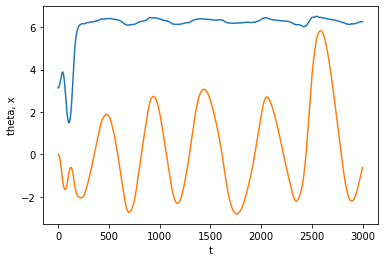

In [9]:
import matplotlib.pyplot as plt
trajectory = np.stack(trajectory)
plt.plot(trajectory[:,0])
plt.plot(trajectory[:,1])
plt.xlabel('t')
plt.ylabel('theta, x')
plt.show()